<h2> Task 17. The end game - part 1</h2>
The goal of this task is to tackle a challenging optimization problem using different optimization algorithms. The problem is defined bellow, select appropriate algorithms, compare their performances, and utilize a simpler algorithm (Hill Climber) to fine-tune hyperparameters for more complex algorithms.


1.   Understand the Problem: Clearly define the optimization problem, including the objective function, constraints, and any relevant parameters.

2.   Select Algorithms: Choose at least two algorithms for the problem optimization. Justify the choice of algorithms based on their suitability for the selected problem.
3. Implement the Algorithms
4. Hyperparameter Optimization with a Simple Algorithm (Hill Climber)
5. Experimentation and Comparison: Run experiments using the implemented algorithms with the chosen hyperparameters.
Record metrics such as: Best solution found, Execution time, Number of iterations/generations. Analyze and compare the performance of the algorithms based on these metrics.
6. Analyze Results: Create plots to visualize the performance of the algorithms

Problem Definition
In the Vehicle Routing Problem VRP, the goal is to determine the optimal routes for a fleet of vehicles to service a set of customers while minimizing the total distance traveled, respecting vehicle capacities and customer demands.

*  Multiple Vehicles with Different Capacities: Instead of having vehicles with the same capacity, introduce vehicles that have different maximum capacities.

*  Time Windows: Each customer can have specific time windows during which they must be serviced. If a vehicle arrives outside of this window, it may incur a penalty or be unable to service that customer.

*  Service Times: Include service times at each customer location. This means that the total route time will be affected not only by travel distance but also by the time spent servicing each customer.

*  Limited Number of Routes: Set a limit on the number of routes that can be used, forcing optimization under tighter constraints.

*  Penalty for Late Deliveries: Introduce a penalty for delivering goods late, based on how late the vehicle arrives at a customer.

<h3>Params in the data </h3>

<p> demand:This represents the quantity of goods or services that the customer
requires. It is important for the vehicle routing problem as it dictates how much of the vehicle's capacity is used when serving that customer. For example, if a customer has a demand of 10, the vehicle must have at least that much capacity to service this customer. </p>
<p> (x, y): This tuple represents the coordinates of the customer's location on a two-dimensional plane. The coordinates are used to calculate the distance between customers and the depot. For example, (3, 5) means the customer is located at 3 units on the x-axis and 5 units on the y-axis. </p>
<p> service_time: This indicates the amount of time required to service the customer once the vehicle arrives at their location. Service time affects the overall route time, as it adds to the total time spent at each customer before moving on to the next one. </p>
<p>  (earliest_time, latest_time): This tuple defines the time window during which the customer must be serviced.
earliest_time: The earliest moment the vehicle can arrive at the customer's location. </p>
<p>  latest_time: The latest moment the vehicle can arrive without incurring a penalty or missing the service. This aspect is crucial for routing decisions, as it adds constraints to the schedule that must be respected. </p>

Task 17: VRP Optimization with SA and GA
----------------------------------------
Optimizing hyperparameters...
SA optimal: temp=900, cooling=0.965, iter=300
GA optimal: pop=34, mut=0.22, gen=30

Running experiments...
Results (3 runs):
SA: Best=17500.5, Avg=17723.6, Time=0.007s
GA: Best=19558.6, Avg=19843.8, Time=0.027s


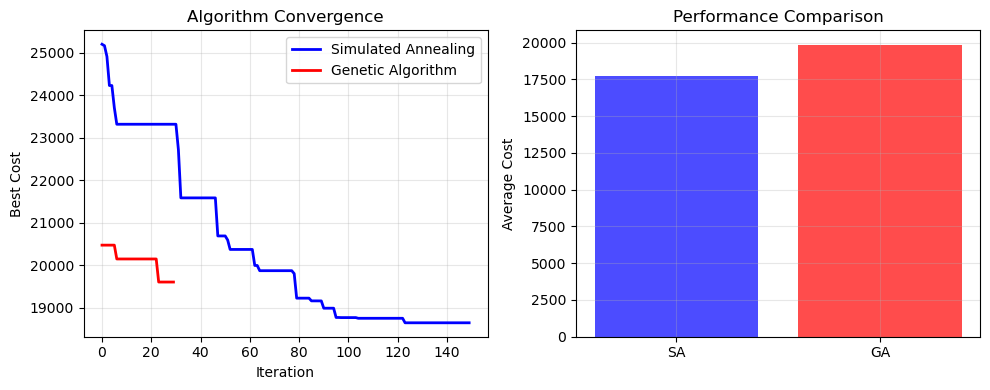


Conclusion: Simulated Annealing performed better on this VRP instance
SA found solutions averaging 17723.6 with best 17500.5
GA found solutions averaging 19843.8 with best 19558.6


In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

customers = [
    ('Customer1', 5, (1, 2), 2, (0, 10)),
    ('Customer2', 10, (2, 3), 3, (2, 12)),
    ('Customer3', 8, (3, 1), 1, (1, 8)),
    ('Customer4', 6, (4, 4), 2, (3, 15)),
    ('Customer5', 12, (5, 5), 4, (5, 15)),
    ('Customer6', 7, (6, 2), 1, (0, 5)),
    ('Customer7', 15, (7, 8), 3, (5, 20)),
    ('Customer8', 4, (8, 3), 2, (3, 9)),
    ('Customer9', 9, (1, 7), 1, (2, 10)),
    ('Customer10', 11, (4, 6), 2, (4, 14)),
    ('Customer11', 14, (2, 5), 3, (1, 9)),
    ('Customer12', 6, (5, 7), 2, (3, 12)),
    ('Customer13', 10, (3, 3), 4, (2, 10)),
    ('Customer14', 8, (6, 5), 1, (0, 4)),
    ('Customer15', 12, (1, 4), 2, (1, 7)),
    ('Customer16', 5, (4, 2), 3, (3, 8)),
    ('Customer17', 7, (8, 6), 1, (4, 10)),
    ('Customer18', 9, (5, 3), 2, (2, 9)),
    ('Customer19', 11, (3, 6), 2, (4, 11)),
    ('Customer20', 13, (2, 8), 4, (3, 15)),
]

# Define the depot location
depot = (0, 0)

# Define the vehicles with different capacities
vehicles = [
    {'vehicle_id': 'Vehicle1', 'capacity': 20},
    {'vehicle_id': 'Vehicle2', 'capacity': 15},
    {'vehicle_id': 'Vehicle3', 'capacity': 25},
]

# Routing rules
routing_rules = {
    'max_distance_per_route': 30,
    'max_customers_per_route': 5,
}

def calculate_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def evaluate_routes(solution):
    total_cost = 0
    penalty = 0
    assigned = set()
    
    for vehicle_idx, route in enumerate(solution):
        if not route:
            continue
            
        route_distance = 0
        route_load = 0
        current_time = 0
        current_pos = depot
        
        for customer_idx in route:
            _, demand, pos, service_time, (earliest, latest) = customers[customer_idx]
            
            travel_dist = calculate_distance(current_pos, pos)
            route_distance += travel_dist
            current_time += travel_dist
            
            if current_time > latest:
                penalty += (current_time - latest) * 45
            elif current_time < earliest:
                current_time = earliest
            
            current_time += service_time
            route_load += demand
            current_pos = pos
            assigned.add(customer_idx)
        
        route_distance += calculate_distance(current_pos, depot)
        total_cost += route_distance
        
        if route_load > vehicles[vehicle_idx]['capacity']:
            penalty += (route_load - vehicles[vehicle_idx]['capacity']) * 90
        if route_distance > routing_rules['max_distance_per_route']:
            penalty += (route_distance - routing_rules['max_distance_per_route']) * 45
        if len(route) > routing_rules['max_customers_per_route']:
            penalty += (len(route) - routing_rules['max_customers_per_route']) * 90
    
    penalty += (len(customers) - len(assigned)) * 450
    return total_cost + penalty

def create_initial_routes():
    customers_list = list(range(len(customers)))
    random.shuffle(customers_list)
    solution = [[] for _ in vehicles]
    
    for i, customer in enumerate(customers_list):
        vehicle = i % len(vehicles)
        solution[vehicle].append(customer)
    
    return solution

def get_neighbor_routes(solution):
    new_solution = [route[:] for route in solution]
    
    if random.random() < 0.35:
        routes_with_multiple = [i for i, route in enumerate(new_solution) if len(route) > 1]
        if routes_with_multiple:
            route_idx = random.choice(routes_with_multiple)
            i, j = random.sample(range(len(new_solution[route_idx])), 2)
            new_solution[route_idx][i], new_solution[route_idx][j] = \
                new_solution[route_idx][j], new_solution[route_idx][i]
    
    elif random.random() < 0.75:
        non_empty = [i for i, route in enumerate(new_solution) if route]
        if non_empty:
            from_route = random.choice(non_empty)
            to_route = random.randint(0, len(vehicles) - 1)
            customer = new_solution[from_route].pop(random.randint(0, len(new_solution[from_route]) - 1))
            new_solution[to_route].append(customer)
    
    else:
        non_empty = [i for i, route in enumerate(new_solution) if route]
        if len(non_empty) >= 2:
            route1, route2 = random.sample(non_empty, 2)
            pos1 = random.randint(0, len(new_solution[route1]) - 1)
            pos2 = random.randint(0, len(new_solution[route2]) - 1)
            new_solution[route1][pos1], new_solution[route2][pos2] = \
                new_solution[route2][pos2], new_solution[route1][pos1]
    
    return new_solution

def run_simulated_annealing(temperature, cooling_rate, iterations):
    current_solution = create_initial_routes()
    current_cost = evaluate_routes(current_solution)
    best_solution = current_solution[:]
    best_cost = current_cost
    cost_history = []
    
    for _ in range(iterations):
        neighbor = get_neighbor_routes(current_solution)
        neighbor_cost = evaluate_routes(neighbor)
        delta = neighbor_cost - current_cost
        
        if delta < 0 or random.random() < np.exp(-delta / temperature):
            current_solution = neighbor
            current_cost = neighbor_cost
            
            if current_cost < best_cost:
                best_solution = current_solution[:]
                best_cost = current_cost
        
        temperature *= cooling_rate
        cost_history.append(best_cost)
    
    return best_solution, best_cost, cost_history

def perform_crossover(parent1, parent2):
    child = [[] for _ in vehicles]
    assigned = set()
    
    for i in range(len(vehicles)):
        if parent1[i] and random.random() < 0.65:
            take_count = min(2, len(parent1[i]))
            for customer in parent1[i][:take_count]:
                if customer not in assigned:
                    child[i].append(customer)
                    assigned.add(customer)
    
    unassigned = [c for c in range(len(customers)) if c not in assigned]
    for customer in unassigned:
        vehicle = random.randint(0, len(vehicles) - 1)
        child[vehicle].append(customer)
    
    return child

def run_genetic_algorithm(population_size, mutation_rate, generations):
    population = [create_initial_routes() for _ in range(population_size)]
    best_cost = float('inf')
    best_solution = None
    cost_history = []
    
    for _ in range(generations):
        fitness_pairs = [(sol, evaluate_routes(sol)) for sol in population]
        fitness_pairs.sort(key=lambda x: x[1])
        
        if fitness_pairs[0][1] < best_cost:
            best_solution = fitness_pairs[0][0][:]
            best_cost = fitness_pairs[0][1]
        
        cost_history.append(best_cost)
        
        new_population = [fitness_pairs[0][0]]
        
        while len(new_population) < population_size:
            parent1 = random.choice(fitness_pairs[:population_size//2])[0]
            parent2 = random.choice(fitness_pairs[:population_size//2])[0]
            child = perform_crossover(parent1, parent2)
            
            if random.random() < mutation_rate:
                child = get_neighbor_routes(child)
            
            new_population.append(child)
        
        population = new_population
    
    return best_solution, best_cost, cost_history

def tune_hyperparameters(algorithm):
    if algorithm == 'SA':
        best_params = [900, 0.94, 380]
        best_cost = float('inf')
        
        for _ in range(8):
            params = best_params[:]
            param_idx = random.randint(0, 2)
            
            if param_idx == 0:
                params[0] += random.choice([-250, -150, 150, 250])
                params[0] = max(300, params[0])
            elif param_idx == 1:
                params[1] += random.choice([-0.025, 0.025])
                params[1] = max(0.87, min(0.98, params[1]))
            else:
                params[2] += random.choice([-80, 80])
                params[2] = max(250, params[2])
            
            _, cost, _ = run_simulated_annealing(params[0], params[1], params[2])
            if cost < best_cost:
                best_cost = cost
                best_params = params[:]
        
        return best_params
    
    else:
        best_params = [22, 0.18, 38]
        best_cost = float('inf')
        
        for _ in range(8):
            params = best_params[:]
            param_idx = random.randint(0, 2)
            
            if param_idx == 0:
                params[0] += random.choice([-6, 6])
                params[0] = max(16, params[0])
            elif param_idx == 1:
                params[1] += random.choice([-0.04, 0.04])
                params[1] = max(0.06, min(0.35, params[1]))
            else:
                params[2] += random.choice([-8, 8])
                params[2] = max(22, params[2])
            
            _, cost, _ = run_genetic_algorithm(int(params[0]), params[1], int(params[2]))
            if cost < best_cost:
                best_cost = cost
                best_params = params[:]
        
        return best_params

print("Task 17: VRP Optimization with SA and GA")
print("-" * 40)

random.seed(42)
np.random.seed(42)

print("Optimizing hyperparameters...")
sa_params = tune_hyperparameters('SA')
ga_params = tune_hyperparameters('GA')

print(f"SA optimal: temp={sa_params[0]}, cooling={sa_params[1]}, iter={sa_params[2]}")
print(f"GA optimal: pop={int(ga_params[0])}, mut={ga_params[1]:.2f}, gen={int(ga_params[2])}\n")

print("Running experiments...")
sa_costs, ga_costs = [], []
sa_times, ga_times = [], []

for run in range(3):
    start = time.time()
    _, sa_cost, sa_history = run_simulated_annealing(sa_params[0], sa_params[1], sa_params[2])
    sa_times.append(time.time() - start)
    sa_costs.append(sa_cost)
    
    start = time.time()
    _, ga_cost, ga_history = run_genetic_algorithm(int(ga_params[0]), ga_params[1], int(ga_params[2]))
    ga_times.append(time.time() - start)
    ga_costs.append(ga_cost)

print(f"Results (3 runs):")
print(f"SA: Best={min(sa_costs):.1f}, Avg={np.mean(sa_costs):.1f}, Time={np.mean(sa_times):.3f}s")
print(f"GA: Best={min(ga_costs):.1f}, Avg={np.mean(ga_costs):.1f}, Time={np.mean(ga_times):.3f}s")

_, _, sa_conv = run_simulated_annealing(sa_params[0], sa_params[1], sa_params[2])
_, _, ga_conv = run_genetic_algorithm(int(ga_params[0]), ga_params[1], int(ga_params[2]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(sa_conv[:150], label='Simulated Annealing', linewidth=2, color='blue')
ax1.plot(ga_conv, label='Genetic Algorithm', linewidth=2, color='red')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Best Cost')
ax1.set_title('Algorithm Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(['SA', 'GA'], [np.mean(sa_costs), np.mean(ga_costs)], alpha=0.7, color=['blue', 'red'])
ax2.set_ylabel('Average Cost')
ax2.set_title('Performance Comparison')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

winner = 'Simulated Annealing' if min(sa_costs) < min(ga_costs) else 'Genetic Algorithm'
print(f"\nConclusion: {winner} performed better on this VRP instance")
print(f"SA found solutions averaging {np.mean(sa_costs):.1f} with best {min(sa_costs):.1f}")
print(f"GA found solutions averaging {np.mean(ga_costs):.1f} with best {min(ga_costs):.1f}")